---
## <center> **손쉽게 따라하는 SAS® Viya® Workbench - Python 사용자편** </center>
---

### **0. Packages 설치**

In [1]:
!pip install packages saspy
import saspy
import numpy as np
import pandas as pd
from sasviya.ml.linear_model import LogisticRegression
from sasviya.ml.svm import SVC
from sasviya.ml.tree import DecisionTreeClassifier, ForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc

Defaulting to user installation because normal site-packages is not writeable


### **1. SAS 연결 및 Library 할당**

In [12]:
sas = saspy.SASsession()
sas.saslib('WRKLIB', path='/workspaces/myfolder/sas-viya-workbench-hands-on/02. SAS 데이터')

Using SAS Config named: default
SAS server started using Context 0001 with SESSION_ID=0001-ses0008
12   libname WRKLIB    '/workspaces/myfolder/sas-viya-workbench-hands-on/02. SAS 데이터'  ;
NOTE: Libref WRKLIB was successfully assigned as follows: 
      Engine:        V9 
      Physical Name: /workspaces/myfolder/sas-viya-workbench-hands-on/02. SAS 데이터



### **2. 데이터 로드**

In [11]:
# 형식 변환 (sas7bdat → Dataframe) 후 로드
churn_parted = sas.sasdata('churn_parted', libref='WRKLIB').to_df()
churn_parted.columns = churn_parted.columns.str.upper()
churn_parted.head(10)

,CALLFAIL,COMPLAINS,SUBLENGTH,CHARGEAMT,SECOFUSE,FREQOFUSE,FREQSMS,DISTCALLNUM,AGEGROUP,TARIFFPLAN,STATUS,AGE,CUSTVALUE,CHURN,_PARTITION_
0,8.0,0.0,38.0,0.0,4370.0,71.0,5.0,17.0,3.0,1.0,1.0,30.0,197.640,0.0,2.0
1,0.0,0.0,39.0,0.0,318.0,5.0,7.0,4.0,2.0,1.0,2.0,25.0,46.035,0.0,1.0
2,10.0,0.0,37.0,0.0,2453.0,60.0,359.0,24.0,3.0,1.0,1.0,30.0,1536.520,0.0,0.0
3,10.0,0.0,38.0,0.0,4198.0,66.0,1.0,35.0,1.0,1.0,1.0,15.0,240.020,0.0,1.0
4,3.0,0.0,38.0,0.0,2393.0,58.0,2.0,33.0,1.0,1.0,1.0,15.0,145.805,0.0,2.0
5,11.0,0.0,38.0,1.0,3775.0,82.0,32.0,28.0,3.0,1.0,1.0,30.0,282.280,0.0,0.0
6,4.0,0.0,38.0,0.0,2360.0,39.0,285.0,18.0,3.0,1.0,1.0,30.0,1235.960,0.0,1.0
7,13.0,0.0,37.0,2.0,9115.0,121.0,144.0,43.0,3.0,1.0,1.0,30.0,945.440,0.0,2.0
8,7.0,0.0,38.0,0.0,13773.0,169.0,0.0,44.0,3.0,1.0,1.0,30.0,557.680,0.0,2.0
9,7.0,0.0,38.0,1.0,4515.0,83.0,2.0,25.0,3.0,1.0,1.0,30.0,191.920,0.0,1.0


### **3. 데이터 분할**  
- 학습(Training), 검증(Validation), 평가(Testing) 데이터 분할

In [10]:
churn_train = churn_parted[churn_parted['_PARTITION_'] == 0]
churn_valid = churn_parted[churn_parted['_PARTITION_'] == 1]
churn_test  = churn_parted[churn_parted['_PARTITION_'] == 2]

print("## Table Size (4:3:3)")
print(f" - Train Set: {churn_train.shape[0]:,}")
print(f" - Valid Set: {churn_valid.shape[0]:,}")
print(f" -  Test Set: {churn_test.shape[0]:,}")
print()
print("## Target Rate")
print(f" - Train Set: {churn_train['CHURN'].mean():.3f}")
print(f" - Valid Set: {churn_valid['CHURN'].mean():.3f}")
print(f" -  Test Set: {churn_test['CHURN'].mean():.3f}")

## Table Size (4:3:3)
 - Train Set: 1,260
 - Valid Set: 946
 -  Test Set: 944

## Target Rate
 - Train Set: 0.157
 - Valid Set: 0.158
 -  Test Set: 0.157


### **4. 변수 분리**  
- 독립변수, 종속변수 분할

In [9]:
# (1) 전체
full_X = churn_train.drop(columns=['CHURN','_PARTITION_'], errors='ignore')
full_y = churn_train['CHURN']

# (2) 학습용
X_train = churn_train.drop(columns=['CHURN','_PARTITION_'], errors='ignore')
y_train = churn_train['CHURN']

# (3) 평가용
X_valid = churn_valid.drop(columns=['CHURN','_PARTITION_'], errors='ignore')
y_valid = churn_valid['CHURN']

# (4) 검증용
X_test = churn_test.drop(columns=['CHURN','_PARTITION_'], errors='ignore')
y_test = churn_test['CHURN']

### **4. 모형 적합**

#### **4.1. 의사결정나무**  
**(1) 모형 학습**

In [ ]:
dt = DecisionTreeClassifier(criterion = "chisquare",
                               max_depth = 10,
                               ccp_alpha = 0)

dt.fit(X_train, y_train)

**(2) 주요 Hyper Parameters**

- **criterion**: `{“chaid”, “chisquare”, “entropy|gain”, “igr|gainratio”, “gini”}`  
  각 트리 노드의 분할 기준을 지정합니다.

- **max_depth**: `int`  
  트리의 최대 깊이를 지정합니다.

- **min_samples_leaf**: `int`  
  각 노드에 최소한으로 있어야 하는 샘플의 수를 지정합니다.

- **ccp_alpha**: `float`  
  회귀 트리의 최소 비용 복잡성 가지치기에 사용할 값을 지정합니다.

- **verbose**: `int`  
  피팅된 모델에 대해 출력할 정보의 양을 지정합니다.

<small> `DecisionTreeClassifier()` 클래스 사용에 대한 자세한 내용은 [문서](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbpymlpg/sasviya-ml-tree-decisiontreeclassifier.htm)를 참고하세요.</small> 

#### **4.2.랜덤포레스트**  
**(1) 모형 학습**

In [ ]:
#fit a random forest model
forest = ForestClassifier(criterion        = "chisquare",
                          n_estimators     = 100,
                          max_depth        = 7,
                          min_samples_leaf = 5,
                          bootstrap        = 0.6,
                          random_state     = 919)

forest.fit(X_train, y_train)

**(2) 주요 Hyper Parameters**

- **n_estimators**: `int`  
  생성할 트리의 수를 지정합니다.

- **bootstrap**: `float`  
  부트스트랩 샘플에 사용할 데이터의 비율을 지정합니다.

- **criterion**: `{“chaid”, “chisquare”, “entropy|gain”, “igr|gainratio”, “gini”}`  
  각 트리 노드에서 분할의 품질을 측정하는 기준을 지정합니다.

- **max_depth**: `int`  
  트리의 최대 깊이를 지정합니다.

- **max_features**: `int`  
  노드를 분할할 때 고려할 입력 변수의 수를 지정합니다(모델 출력에서 “M”으로 표시). 각 트리마다 입력 변수들 중에서 무작위로 선택된 변수들로 분할을 진행합니다. 기본값은 입력 변수 수의 제곱근입니다.

- **min_samples_leaf**: `int`  
  각 노드에 최소한으로 있어야 하는 샘플의 수를 지정합니다.

- **n_bins**: `int`  
  숫자형 변수에 대해 사용할 빈의 수를 지정합니다.

- **oob_score**: `bool`  
  모델 훈련 시 OOB(Out-of-Bag) 오류를 계산할지 여부를 지정합니다.

- **random_state**: `int`  
  난수 생성에 사용할 시드를 지정합니다.

- **verbose**: `int`  
  피팅된 모델에 대해 출력할 정보의 양을 지정합니다.


<small> `ForestClassifier()` 클래스 사용에 대한 자세한 내용은 [문서](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbpymlpg/sasviya-ml-tree-forestclassifier.htm)를 참고하세요.</small> 

#### **4.3. 로지스틱회귀**  
**(1) 모형 학습**

In [ ]:
lr = LogisticRegression(solver   = 'lbfgs',
                            tol      = 1e-4,
                            max_iter = 1000)

lr.fit(X_train, y_train)

**(2) 주요 Hyper Parameters**

- **tol**: `float`  
상대적인 기울기 수렴 기준을 지정합니다.

- **fit_intercept**: `bool`  
모델에 편향 항을 포함할지 여부를 지정합니다.

- **max_iter**: `float`  
훈련 반복의 최대 횟수를 지정합니다.

- **max_time**: `float`  
최대 훈련 시간을 초 단위로 지정합니다.

- **solver**: `str`  
사용할 최적화 알고리즘을 지정합니다. 유효한 옵션은 다음과 같습니다:
  - “congra”: 공액 기울기 방법
  - “dbldog”: 더블-도그레그 방법
  - “lbfgs”: 제한된 메모리 BFGS 해결기
  - “newrap”: 라인 탐색 및 리지법을 사용한 뉴턴-랩슨 방법
  - “nmsimp”: 넬더-미드 심플렉스 방법
  - “nrridg”: 리지법을 사용한 뉴턴-랩슨 방법
  - “quanew | duquanew”: 이중 준-뉴턴 최적화

- **selection**: `str`  
사용할 변수 선택 방법을 지정합니다. 유효한 옵션은 다음과 같습니다:
  - “backward”: 후진 선택법
  - “forward”: 전진 선택법
  - “lasso”: Lasso 방법
  - “stepwise”: 단계적 선택법

- **verbose**: `int`  
피팅된 모델에 대해 출력할 정보의 양을 지정합니다. 유효한 옵션은 다음과 같습니다:
  - 0: 출력 없음
  - 1: 반복 이력
  - 2: 반복 이력 및 피팅 통계

<small> `LogisticRegression()` 클래스 사용에 대한 자세한 내용은 [문서](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbpymlpg/sasviya-ml-linear_model-logisticregression.htm)를 참고하세요.</small> 

#### **4.4. 지지벡터머신**  
**(1) 모형 학습**

In [10]:
#fit a support vector machine classifier
svm = SVC(C=1.0,
          kernel="rbf")

svm.fit(X_train, y_train)

SVC(kernel="rbf")

**(2) 주요 Hyper Parameters**

- **max_iter**: `int`  
훈련 반복의 최대 횟수를 지정합니다.

- **C**: `float`  
비용 정규화 파라미터를 지정합니다.

- **kernel**: `{“linear”, “poly”, “polynomial”, “rbf”, “sigmoid”}`  
사용할 커널의 유형을 지정합니다.

- **degree**: `int`  
다항식 커널의 차수를 지정합니다. 커널이 “polynomial”이 아닌 경우는 무시됩니다.

- **sigma**: `“auto”`, `“scale”` 또는 `float`  
RBF 및 Sigmoid 커널의 커널 파라미터를 지정합니다.

- **coef0**: `float`  
Sigmoid 커널의 두 번째 파라미터를 지정합니다.

- **method**: `{“activeset”, “cd”, “ipoint”}` 또는 `None`  
모델을 피팅할 때 사용하는 최적화 방법을 지정합니다.
  - **Active-Set**: 모든 커널에서 사용 가능하며, RBF 및 Sigmoid 커널과 3차 이상의 다항식 커널의 기본값입니다.
  - **Interior Point**: 선형 커널 및 다항식 커널에서 사용 가능하며, 선형 커널과 3차 이하의 다항식 커널의 기본값입니다.
  - **Coordinate Descent**: 선형 커널에서만 사용 가능합니다.

- **tol**: `float`  
조기 중지를 위한 허용 오차 임계값을 지정합니다.

- **random_state**: `int`  
난수 생성에 사용할 시드를 지정합니다.

- **scale**: `bool`  
True로 설정하면 훈련 전에 숫자 변수를 스케일링합니다.

- **verbose**: `int`  
피팅된 모델에 대해 출력할 정보의 양을 지정합니다.

<small> `SVC()` 클래스 사용에 대한 자세한 내용은 [문서](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbpymlpg/sasviya-ml-svm-svc.htm)를 참고하세요.</small> 

#### **4.5. 그레디언트부스팅**  
**(1) 모형 학습**

In [12]:
#fit a tree-based gradient boosting
gradboost = GradientBoostingClassifier(n_estimators     = 100,
                                       max_depth        = 4,
                                       min_samples_leaf = 5,
                                       learning_rate    = 0.1,
                                       subsample        = 0.8,
                                       random_state     = 919)

gradboost.fit(X_train, y_train)

GradientBoostingClassifier(subsample=0.8, random_state=919)

**(2) 주요 Hyper Parameters**

- **n_bins**: `int`  
  숫자형 변수에 대해 사용할 빈의 수를 지정합니다. 기본값은 50입니다.

- **min_samples_leaf**: `int`  
  각 노드에 최소한으로 있어야 하는 샘플의 수를 지정합니다. 기본값은 5입니다.

- **n_estimators**: `int`  
  생성할 트리의 수를 지정합니다. 기본값은 100입니다.

- **max_depth**: `int`  
  트리의 최대 깊이를 지정합니다. 기본값은 4입니다.

- **max_features**: `float`  
  노드를 분할할 때 고려할 입력 변수의 수를 지정합니다. 기본값은 입력 변수 수에 설정됩니다.

- **learning_rate**: `float`  
  각 트리의 학습률을 지정합니다. 기본값은 0.1입니다.

- **subsample**: `float`  
  각 트리를 구축하는 데 사용할 데이터의 비율을 지정합니다. 기본값은 0.5입니다.

- **l1_penalty**: `float`  
  예측에 대한 L1 정규화 값을 지정합니다. 기본값은 0입니다.

- **l2_penalty**: `float`  
  예측에 대한 L2 정규화 값을 지정합니다. 기본값은 1입니다.

- **random_state**: `float`  
  난수 생성기의 시드를 지정합니다. 기본값은 컴퓨터 시계를 기반으로 한 난수 스트림입니다. 재현 가능한 난수 시퀀스를 원할 경우 0보다 큰 값을 지정합니다.

- **verbose**: `int`  
  피팅된 모델에 대해 출력할 정보의 양을 지정합니다.

- **calc_feature_importances**: `bool`  
  특성 중요도를 계산할지 여부를 지정합니다.

- **validation_fraction**: `float`  
  훈련 샘플에서 검증에 사용할 비율을 지정합니다. 검증 비율이 0보다 크면 조기 중지 모드가 활성화됩니다.

- **n_iter_no_change**: `int`  
  조기 중지를 위한 최대 훈련 반복 횟수를 지정합니다. 검증 비율이 지정되지 않으면 무시됩니다.

- **tol**: `float`  
  이전 반복에 대한 상대적인 변화로 조기 중지를 위한 허용 오차 값을 지정합니다. 검증 비율이 지정되지 않으면 무시됩니다.

<small> `GradientBoostingClassifier()` 클래스 사용에 대한 자세한 내용은 [문서](https://go.documentation.sas.com/doc/en/workbenchcdc/v_001/vwbpymlpg/sasviya-ml-tree-gradientboostingclassifier.htm)를 참고하세요.</small> 

### **5.모형 평가**
- 모형 리스트 및 이름 정의

In [38]:
# 모델 리스트 및 이름 정의
models = [
    ("Decision Tree", "dt", dt),
    ("Random Forest", "rf", forest),
    ("Logistic Regression", "lr", lr),
    ("Support Vector Machine", "svm", svm),
    ("Gradient Boosting", "gbm", gradboost)
]

#### **5.1. 모형 평가 지표 산출**
- 주요 평가 지표
  - **Accuracy(정확도)**: 전체 샘플 중 올바르게 분류된 비율
  - **Precision(정밀도)**: 해당 클래스에 대해 양성으로 예측된 것 중 실제 양성의 비율
  - **Recall(재현율)**: 실제 양성 중 모델이 양성으로 예측한 비율
  - **F1-Score(F1 점수)**: 정밀도와 재현율의 조화 평균 (데이터 불균형 시 유용)

In [21]:
# 결과 저장용 리스트
metrics = []
for name, abbr, model in models:
    # 학습용, 평가용, 테스트용 데이터 예측
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)

    # 평가지표 계산
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_valid = accuracy_score(y_valid, y_valid_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    precision_train = precision_score(y_train, y_train_pred, average="binary")
    precision_valid = precision_score(ㅁy_valid, y_valid_pred, average="binary")
    precision_test = precision_score(y_test, y_test_pred, average="binary")

    recall_train = recall_score(y_train, y_train_pred, average="binary")
    recall_valid = recall_score(y_valid, y_valid_pred, average="binary")
    recall_test = recall_score(y_test, y_test_pred, average="binary")

    f1_train = f1_score(y_train, y_train_pred, average="binary")
    f1_valid = f1_score(y_valid, y_valid_pred, average="binary")
    f1_test = f1_score(y_test, y_test_pred, average="binary")

    # 결과 저장
    metrics.append({
        "Model": name,
        "Accuracy_Train": round(accuracy_train, 3),
        "Accuracy_Valid": round(accuracy_valid, 3),
        "Accuracy_Test": round(accuracy_test, 3),
        "Precision_Train": round(precision_train, 3),
        "Precision_Valid": round(precision_valid, 3),
        "Precision_Test": round(precision_test, 3),
        "Recall_Train": round(recall_train, 3),
        "Recall_Valid": round(recall_valid, 3),
        "Recall_Test": round(recall_test, 3),
        "F1_Score_Train": round(f1_train, 3),
        "F1_Score_Valid": round(f1_valid, 3),
        "F1_Score_Test": round(f1_test, 3),
    })

# 결과 출력
metrics_df = pd.DataFrame(metrics)

In [22]:
metrics_df

,Model,Accuracy_Train,Accuracy_Valid,Accuracy_Test,Precision_Train,Precision_Valid,Precision_Test,Recall_Train,Recall_Valid,Recall_Test,F1_Score_Train,F1_Score_Valid,F1_Score_Test
0,Support Vector Machine,0.899,0.893,0.886,0.859,0.843,0.778,0.429,0.396,0.378,0.572,0.539,0.509
1,Random Forest,0.952,0.936,0.924,0.883,0.900,0.811,0.798,0.664,0.669,0.838,0.764,0.733
2,Gradient Boosting,0.983,0.951,0.949,0.936,0.893,0.838,0.960,0.785,0.838,0.948,0.836,0.838


#### **5.2. ROC 그래프**

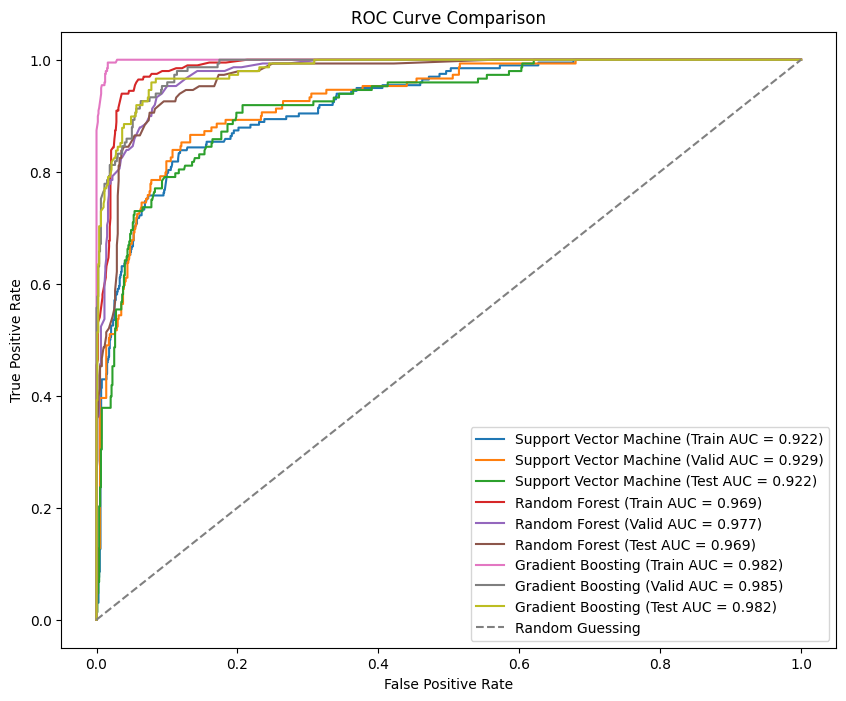

In [23]:
# ROC 커브 그리기
plt.figure(figsize=(10, 8))

for name, abbr, model in models:
    y_train_pred_proba = model.predict_proba(X_train).iloc[:, 1]
    y_valid_pred_proba = model.predict_proba(X_valid).iloc[:, 1]
    y_test_pred_proba = model.predict_proba(X_test).iloc[:, 1]

    # ROC 커브 계산
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
    auc_train = auc(fpr_train, tpr_train)

    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)
    auc_valid = auc(fpr_valid, tpr_valid)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)
    auc_test = auc(fpr_test, tpr_test)

    # ROC 커브 그리기
    plt.plot(fpr_train, tpr_train, label=f"{name} (Train AUC = {auc_test:.3f})")
    #plt.plot(fpr_valid, tpr_valid, label=f"{name} (Valid AUC = {auc_valid:.3f})")
    plt.plot(fpr_test, tpr_test, label=f"{name} (Test AUC = {auc_test:.3f})")
        

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")  # 랜덤 분류 기준선
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

#### **5.3. 향상도 그래프**

In [ ]:
# Lift 차트 그리기
plt.figure(figsize=(10, 8))

for name, abbr, model in models:
    y_train_pred_proba = model.predict_proba(X_train).iloc[:, 1]
    y_valid_pred_proba = model.predict_proba(X_valid).iloc[:, 1]
    y_test_pred_proba = model.predict_proba(X_test).iloc[:, 1]

    # 실제 값과 예측된 확률을 기준으로 데이터 정렬
    train_data = np.array(list(zip(y_train, y_train_pred_proba)))
    train_data = train_data[train_data[:, 1].argsort()[::-1]]  # 확률값 내림차순 정렬
    valid_data = np.array(list(zip(y_valid, y_valid_pred_proba)))
    valid_data = valid_data[valid_data[:, 1].argsort()[::-1]]  # 확률값 내림차순 정렬
    test_data = np.array(list(zip(y_test, y_test_pred_proba)))
    test_data = test_data[test_data[:, 1].argsort()[::-1]]  # 확률값 내림차순 정렬

    # 누적 리프트 계산
    train_lift = np.cumsum(train_data[:, 0]) / np.sum(train_data[:, 0])
    valid_lift = np.cumsum(valid_data[:, 0]) / np.sum(valid_data[:, 0])
    test_lift = np.cumsum(test_data[:, 0]) / np.sum(test_data[:, 0])

    # 리프트 차트 그리기
    plt.plot(np.arange(1, len(train_lift) + 1) / len(train_lift), train_lift, label=f"{name} (Train Lift)")
    plt.plot(np.arange(1, len(valid_lift) + 1) / len(valid_lift), valid_lift, label=f"{name} (Valid Lift)")
    plt.plot(np.arange(1, len(test_lift) + 1) / len(test_lift), test_lift, label=f"{name} (Test Lift)")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guessing")  # 랜덤 분류 기준선
plt.xlabel("Percent of Samples")
plt.ylabel("Lift")
plt.title("Lift Chart Comparison")
plt.legend(loc="lower right")
plt.show()


### **6. 스코어링**

In [44]:
# 각 모델에 대해 예측값과 확률 계산 후 결과 저장
for name, abbr, model in models:
    y_pred = pd.DataFrame(model.predict(full_X), columns=['I_CHURN'])
    y_pred_proba = pd.DataFrame(model.predict_proba(full_X), columns=['P_CHURN0', 'P_CHURN1'])
    result = pd.concat([full_X, full_y, y_pred, y_pred_proba], axis=1)

    # 모델 이름을 키로 하고 결과 데이터프레임을 값으로 저장
    globals()[f"churn_{abbr}_score"] = result

### **7. 결과 저장**

In [49]:
sas.df2sd(churn_dt_score, table='churn_dt_score', libref='WRKLIB')
sas.df2sd(churn_rf_score, table='churn_rf_score', libref='WRKLIB')
sas.df2sd(churn_lr_score, table='churn_lr_score', libref='WRKLIB')
sas.df2sd(churn_svm_score, table='churn_svm_score', libref='WRKLIB')
sas.df2sd(churn_gbm_score, table='churn_gbm_score', libref='WRKLIB')

/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/saspy/sasiohttp.py:1663: UserWarning: Note that Indexes are not transferred over as columns. Only actual columns are transferred
  warnings.warn("Note that Indexes are not transferred over as columns. Only actual columns are transferred")
/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/saspy/sasiohttp.py:1663: UserWarning: Note that Indexes are not transferred over as columns. Only actual columns are transferred
  warnings.warn("Note that Indexes are not transferred over as columns. Only actual columns are transferred")
/workspaces/myfolder/.user-python-packages/lib/python3.11/site-packages/saspy/sasiohttp.py:1663: UserWarning: Note that Indexes are not transferred over as columns. Only actual columns are transferred
  warnings.warn("Note that Indexes are not transferred over as columns. Only actual columns are transferred")


Libref  = WRKLIB
Table   = churn_gbm_score
Dsopts  = {}
Results = Pandas

### **8. SAS 연결 종료**

In [50]:
sas.endsas()

SAS server terminated for SESSION_ID=0001-ses0006


0